In [1]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline as pipe

from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import optuna
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
def format_pl():
  """FLOAT DISPLAY FORMATTING"""
  pl.Config.set_fmt_float("mixed")
  """STRING FORMATTING"""
  pl.Config.set_fmt_str_lengths(50)
  """TABLE FORMATTING"""
  pl.Config.set_tbl_rows(8)
  pl.Config.set_tbl_cols(30)
  pl.Config.set_tbl_width_chars(200)
  pl.Config.set_tbl_cell_alignment("RIGHT")
  pl.Config.set_tbl_hide_dtype_separator(True)
  pl.Config.set_tbl_hide_column_data_types(True)

format_pl()

In [3]:
## Helper functions
eps = 1e-7
logit   = lambda p: np.log(np.clip(p, eps, 1-eps) / (1 - np.clip(p, eps, 1-eps)))
sigmoid = lambda x: 1/(1 + np.exp(-x)) 
RMSE    = lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2))

In [4]:
train = pl.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

In [5]:
train.head()

id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,"""urban""",2,0.06,35,"""daylight""","""rainy""",false,true,"""afternoon""",false,true,1,0.13
1,"""urban""",4,0.99,35,"""daylight""","""clear""",true,false,"""evening""",true,true,0,0.35
2,"""rural""",4,0.63,70,"""dim""","""clear""",false,true,"""morning""",true,false,2,0.3
3,"""highway""",4,0.07,35,"""dim""","""rainy""",true,true,"""morning""",false,false,1,0.21
4,"""rural""",1,0.58,60,"""daylight""","""foggy""",false,false,"""evening""",true,false,1,0.56


In [6]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


# Quick EDA

In [7]:
train.select(
    pl.all().is_null().sum()
)

id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
train.select(
    pl.all().n_unique().sum()
)

id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
517754,3,4,261,5,3,3,2,2,3,2,2,8,98


In [9]:
train.is_duplicated().sum()

0

In [10]:
train.group_by(
    pl.col("road_type")
).agg(
    pl.col("accident_risk").mean().alias("mean_accident_risk"),
    pl.col("accident_risk").median().alias("median_accident_risk"),
    pl.col("road_type").count().alias("count")
)

road_type,mean_accident_risk,median_accident_risk,count
"""urban""",0.357456,0.35,171363
"""rural""",0.349997,0.34,172719
"""highway""",0.349734,0.34,173672


In [11]:
train.group_by(
    pl.col("num_lanes")
).agg(
    pl.col("accident_risk").mean().alias("mean_accident_risk"),
    pl.col("accident_risk").median().alias("median_accident_risk"),
    pl.col("road_type").count().alias("count")
).sort(by="num_lanes")

num_lanes,mean_accident_risk,median_accident_risk,count
1,0.351317,0.34,131168
2,0.353795,0.34,130054
3,0.357308,0.35,127414
4,0.347161,0.34,129118


In [12]:
train.group_by(
    pl.col("num_reported_accidents")
).agg(
    pl.col("accident_risk").mean().alias("mean_accident_risk"),
    pl.col("accident_risk").median().alias("median_accident_risk"),
    pl.col("road_type").count().alias("count")
).sort(by="num_reported_accidents")

num_reported_accidents,mean_accident_risk,median_accident_risk,count
0,0.338785,0.33,125269
1,0.330684,0.32,209674
2,0.342967,0.34,145965
3,0.550093,0.55,34197
4,0.68518,0.75,2392
5,0.629091,0.78,231
6,0.515833,0.73,24
7,0.1,0.1,2


In [13]:
time_weather_accident = train.group_by(
    pl.col("time_of_day", "weather")
).agg(
    pl.col("accident_risk").mean().alias("mean_accident_risk"),
    pl.col("accident_risk").median().alias("median_accident_risk"),
    pl.col("time_of_day").count().alias("count"),    
).sort(
    by=["time_of_day", "weather"]
).to_pandas()

time_weather_accident

,time_of_day,weather,mean_accident_risk,median_accident_risk,count
0,afternoon,clear,0.308212,0.30,60018
1,afternoon,foggy,0.385147,0.37,59846
2,afternoon,rainy,0.362577,0.35,51643
3,evening,clear,0.314105,0.31,58811
4,evening,foggy,0.385770,0.37,62822
5,evening,rainy,0.363326,0.35,51204
6,morning,clear,0.307961,0.30,60477
7,morning,foggy,0.388054,0.37,58795
8,morning,rainy,0.358728,0.34,54138


Text(0, 0.5, 'Mean Accident Risk')

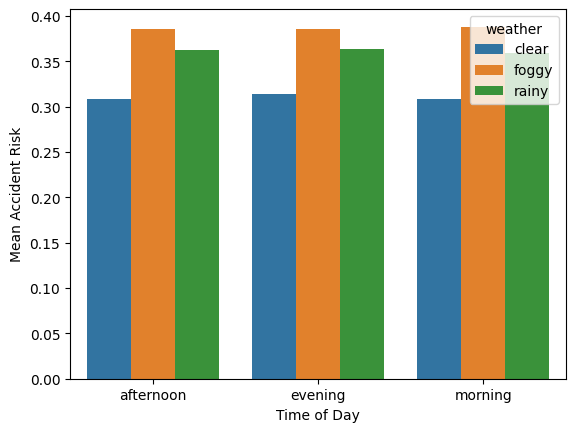

In [14]:
sea.barplot(data=time_weather_accident, x="time_of_day", y="mean_accident_risk", hue="weather")
plt.xlabel("Time of Day")
plt.ylabel("Mean Accident Risk")

<Axes: xlabel='curvature', ylabel='accident_risk'>

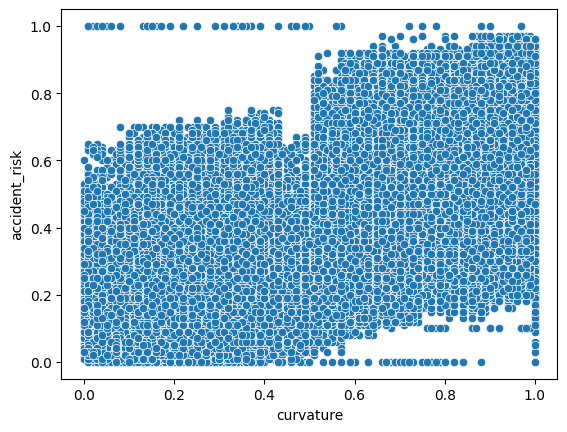

In [15]:
sea.scatterplot(x=train["curvature"], y=train["accident_risk"])

# Preparing Dataset

In [16]:
train_pd = train.to_pandas().drop(columns=["id"])
bool_features = ["road_signs_present", "public_road", "holiday", "school_season"]


X = train_pd.copy()
X[bool_features] = X[bool_features].astype(np.uint8)

y = X.pop("accident_risk")
y_logit = logit(y)

In [17]:
def cross_validate(model, X, y_logit, n_splits=10, store_oof=True, save_n_models=False, model_prefix=None):
    kfold = KFold(n_splits=n_splits, random_state=3126, shuffle=True)
    rmse  = np.zeros(n_splits)
    if store_oof:
        y_oof = np.zeros_like(y_logit)
    history = {}
    
    for k,(train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, y_train = X.iloc[train_idx], y_logit[train_idx]
        X_val,   y_val   = X.iloc[val_idx],   y_logit[val_idx]
        
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        if save_n_models:
            model_filename = f"{model_prefix}_{k+1}.joblib"
            joblib.dump(cloned_model, model_filename)
            
        ## Get logit predictions
        y_pred = cloned_model.predict(X_val)
        ## If store_oof is enabled, stores the oof prediction
        if store_oof:
            y_oof[val_idx] = y_pred
        ## Stores RMSE
        rmse[k] = RMSE(sigmoid(y_val), sigmoid(y_pred))
        ## Saves model if wanted
       
            

    history["rmse"] = rmse
    if store_oof:
        history["y_oof"] = y_oof
    return history

In [18]:
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day']
num_features = ["curvature", "speed_limit"]

preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(drop="first"), cat_features),
     ("numerical", StandardScaler(), num_features)],
    remainder="passthrough",
    n_jobs=-1
)

# Tuning ElasticNet on Logits

In [19]:
# def objective(trial, X, y_logit):
#     # Suggest hyperparameters
#     alpha    = trial.suggest_float("alpha", 1e-4, 10.0, log=True)
#     l1_ratio = trial.suggest_float("l1_ratio", 0.005, 1.0)

#     model = pipe(preprocessor,
#                  ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=3126, max_iter=10000))
#     history = cross_validate(model, X, y_logit, store_oof=False)
#     return history["rmse"].mean()

# study = optuna.create_study(direction="minimize")  
# study.optimize(lambda trial: objective(trial, X, y_logit), n_trials=100)

In [20]:
# ElasticNet Best params: {'alpha': 0.018360331209412065, 'l1_ratio': 0.4152962096107638}
# ElasticNet Best RMSE: 0.07530080149513488
enet_params = {
    'alpha': 0.018360331209412065, 
    'l1_ratio': 0.4152962096107638
}

# Tuning Lasso on Logits

In [21]:
# def objective(trial, X, y_logit):
#     alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)

#     model = pipe(preprocessor,
#                  Lasso(alpha=alpha, random_state=3126))
#     history = cross_validate(model, X, y_logit, store_oof=False)
#     return history["rmse"].mean()

# study = optuna.create_study(direction="minimize")  
# study.optimize(lambda trial: objective(trial, X, y_logit), n_trials=100)

In [22]:
# Lasso Best params:  {'alpha': 0.012852265770746055}
# Lasso Best RMSE:  0.07534884691731689
lasso_params = {
    'alpha': 0.012852265770746055
}

# Tuning Ridge on Logits

In [23]:
# def objective(trial, X, y_logit):
#     alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)

#     model = pipe(preprocessor,
#                  Ridge(alpha=alpha, random_state=3126))
#     history = cross_validate(model, X, y_logit, store_oof=False)
#     return history["rmse"].mean()

# study = optuna.create_study(direction="minimize")  
# study.optimize(lambda trial: objective(trial, X, y_logit), n_trials=100)

In [24]:
# Ridge Best params:  {'alpha': 9.995174955024535}
# Ridge Best RMSE:  0.07640762729883627
ridge_params = {
    'alpha': 9.995174955024535
}

# Evaluating ElasticNet

In [25]:
enet = pipe(preprocessor,
            ElasticNet(**enet_params, random_state=3126, max_iter=10000))
history = cross_validate(enet, X, y_logit, store_oof=True, save_n_models=True, model_prefix="enet")

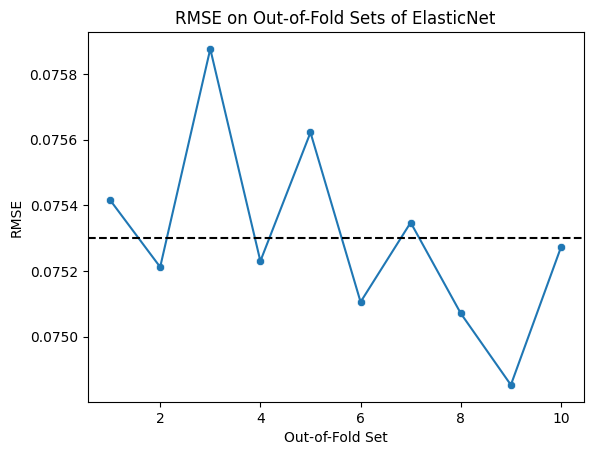

In [26]:
sea.scatterplot(x=np.arange(1,11), y=history["rmse"])
sea.lineplot(x=np.arange(1,11), y=history["rmse"])
plt.axhline(y=history["rmse"].mean(), linestyle="dashed", color="black")
plt.title("RMSE on Out-of-Fold Sets of ElasticNet")
plt.xlabel("Out-of-Fold Set")
plt.ylabel("RMSE")
plt.show()

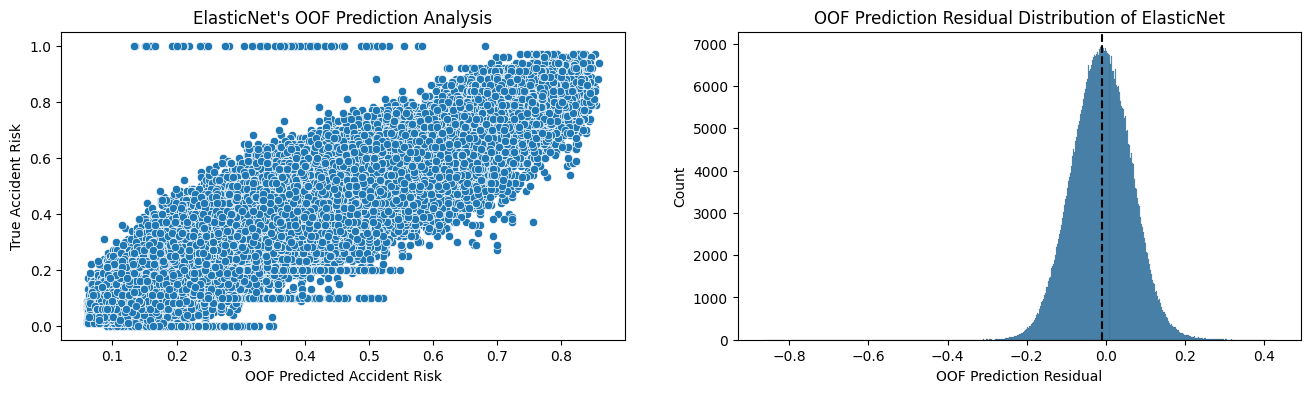

In [27]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=sigmoid(history["y_oof"]), y=y)
plt.xlabel("OOF Predicted Accident Risk")
plt.ylabel("True Accident Risk")
plt.title("ElasticNet's OOF Prediction Analysis")

plt.subplot(122)
sea.histplot(sigmoid(history["y_oof"])-y)
plt.axvline(x=(sigmoid(history["y_oof"])-y).mean(), color="black", linestyle="dashed")
plt.xlabel("OOF Prediction Residual")
plt.ylabel("Count")
plt.title("OOF Prediction Residual Distribution of ElasticNet")

plt.show()

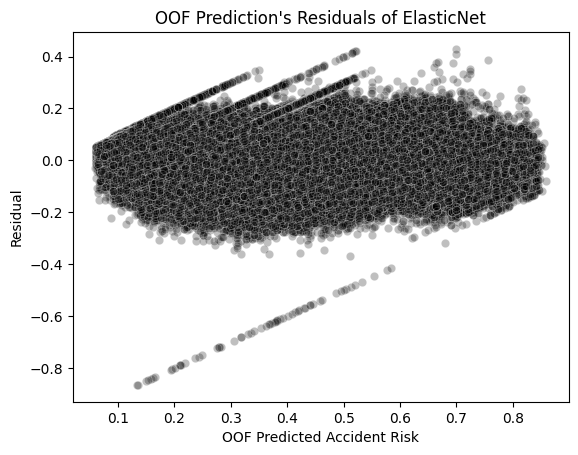

In [28]:
sea.scatterplot(x=sigmoid(history["y_oof"]), y=sigmoid(history["y_oof"])-y, alpha=.25, color="black")
plt.xlabel("OOF Predicted Accident Risk")
plt.ylabel("Residual")
plt.title("OOF Prediction's Residuals of ElasticNet")
plt.show()

# Prediction on Test Data

In [29]:
test.drop(columns=["id"], inplace=True)
test[bool_features] = test[bool_features].astype(np.uint8)

y_pred = np.zeros(len(test))
for k in range(1, 11):
    enet = joblib.load(f"/kaggle/working/enet_{k}.joblib")
    y_pred += sigmoid(enet.predict(test))
y_pred /= 10

sample_submission["accident_risk"] = y_pred
sample_submission

,id,accident_risk
0,517754,0.327972
1,517755,0.149493
2,517756,0.197327
3,517757,0.439344
4,517758,0.308805
...,...,...
172580,690334,0.161733
172581,690335,0.560515
172582,690336,0.212687
172583,690337,0.161821


In [30]:
sample_submission.to_csv("submission.csv", index=False)